# Environment Setup

In [1]:
#install the needed libraries
!pip install bert-for-tf2
!pip install sentencepiece
!pip install hottbox
!pip install pandas-profiling
#!pip install torch
#!apt-get install texlive texlive-xetex texlive-latex-extra pandoc

     |████████████████████████████████| 40kB 1.8MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.13.5-cp36-none-any.whl size=29948 sha256=d8f4d7918ee587e5b5af386cad532f89b3d9e45d19e5c737c6de3dadebbb8341
  Stored in directory: /root/.cache/pip/wheels/ed/11/48/86aff8a0442aa4728c921027a4100ac28878e9d977e76e2d52
  Created wheel for py-params: filename=py_params-0.8.3-cp36-none-any.whl size=4690 sha256=de161782fa6110a6530a7411ae99659bb26b4cfe625a42471232084aab5c8ffd
  Stored in directory: /root/.cache/pip/wheels/1a/98/f8/502fc6b5a7c969276f611efeef0d074c871092d38672203b27
  Created wheel for params-flow: filename=params_flow-0.7.4-cp36-none-any.whl size=16195 sha256=98cca1670d57e5022a4159f229fbf29c6487bac1bfb0e564d5a30f9f7c333d90
  Stored in directory: /root/.cache/pip/wheels/86/30/40/507b60d68b67ac87f35e95c98f5b296a32f146d5ae1d1d5aa7
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.0MB 2.7MB/s 
     |█████████████████████████████

In [2]:
#set up env to use tf2
try:
    %tensorflow_version 2.x
except Exception:
    pass

#import the libraries that we will need.
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

import bert

TensorFlow 2.x selected.


In [0]:
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K

In [0]:
import pandas as pd
import pandas_profiling
import numpy as np
import nltk

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import math
import io
import os
import zipfile
import time

# Suppress new window for plots
%matplotlib inline 

In [0]:
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from pprint import pprint
from collections import Counter

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14266230190064600033, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3323534275880078480
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7995725658679716914
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12252753588280866404
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [7]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Functions

##### Global variables

In [0]:
path_to_data = "/content/drive/My Drive/Colab Notebooks/W266 Final Project/data/"
#zip_filename = "ticket_data_10_years_post_rtf.zip"
#csv_filename = "ticket_data_10_years_post_rtf.csv"
csv_filename = "ticket_data_dec_19_post_rtf.csv"


##### Data pre-processing functions

In [0]:
def text_company(df, text_field):  
  print("Starting text_company()...")
  start = time.time()
  df[text_field] = df[text_field].str.lower()
  end = time.time()
  print("Finished making it lowercase:", (end - start))
  
  start = time.time()  
  df[text_field] = df[text_field].str.replace(r"greenshades support", "clientswsupport")
  end = time.time()
  print("Finished removing 'greenshades support':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades software support", "clientswsupport")
  end = time.time()  
  print("Finished removing 'greenshades software support':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades partner support", "partnerswsupport")
  end = time.time()
  print("Finished removing 'greenshades partner support':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades ticket", "ticket")
  end = time.time()
  print("Finished removing 'greenshades ticket':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades online", "")
  end = time.time()
  print("Finished removing 'greenshades online':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"www.greenshades.com", "")
  end = time.time()
  print("Finished removing 'www.greenshades.com':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshadesonline.com", "")
  end = time.time()
  print("Finished removing 'greenshadesonline.com':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades", "")
  end = time.time()
  print("Finished removing 'greenshades':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"green shades", "")
  end = time.time()
  print("Finished removing 'green shades':", (end - start))
  print("Finished text_company().")
  return df

In [0]:
def text_normalize(df, text_field):
  print("Starting text_normalize()...")
  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"<[^>]+>", "") # Delete any string between "<" and ">"
  end = time.time()
  print("Finished deleting strings between <>")
  print (end - start)

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"www.*?.com", "") 
  end = time.time()  
  print("Finished deleting websites:", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
  end = time.time()  
  print("Finished deleting http\S+:", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"\d+", "") # Remove any strings of numbers
  end = time.time()  
  print("Finished deleting numbers:", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"@\S+", "")
  end = time.time()  
  print("Finished removing S+:", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9]", " ")
  end = time.time()  
  print("Finished removing any non alpha numerics:", (end - start))

  print("Finished text_normalize().")
  return df

In [0]:
# Lemmatize clean text
lemmatizer = WordNetLemmatizer()
def text_lemmatize_orig(df, tokenized_field):  
  print("Starting text_lemmatize()...")
  printAfter = 10000
  print("Total lines in loop")
  print(len(df[tokenized_field]))
  start = time.time()
  for i in range(0, len(df[tokenized_field])):
    df[tokenized_field][i] = lemmatize_sentence(df[tokenized_field][i])
    if i % printAfter == 0:
      print("Finished lines:", i)
      end = time.time()
      print(end - start)
      start = time.time()
  print("Finished text_lemmatize().")

  return df

In [0]:
# Lemmatize clean text
lemmatizer = WordNetLemmatizer()

def text_lemmatize(df, tokenized_field, new_lemmatized_field):  
  print("Starting text_lemmatize()...")
  printAfter = 100000
  print("Total lines in loop")
  print(len(df[tokenized_field]))
  start = time.time()

  new_lemmas = [[]]*len(df[tokenized_field])

  copytoken_time = 0
  pos_tag_time = 0
  wordnet_time = 0
  lemmatize_time = 0

  for i in range(0, len(df[tokenized_field])):   

    start_inner = time.time()
    tokenized_sentence = df[tokenized_field][i]
    end_inner = time.time()
    copytoken_time += (end_inner - start_inner)    
    
    start_inner = time.time()
    nltk_tagged = nltk.pos_tag(tokenized_sentence)  
    end_inner = time.time()
    pos_tag_time += (end_inner - start_inner)    
    
    start_inner = time.time()
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    end_inner = time.time()
    wordnet_time += (end_inner - start_inner)

    start_inner = time.time()
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    end_inner = time.time()    
    lemmatize_time += (end_inner - start_inner)
    
    start_inner = time.time()
    new_lemmas[i] = lemmatized_sentence
    end_inner = time.time()
    copytoken_time += (end_inner - start_inner)    
    

    if i % printAfter == 0 and i != 0:
      print("Finished lines:", i)
      end = time.time()
      print(end - start)
      start = time.time()
      print("POS Tab Time:", pos_tag_time)
      print("Wordnet Time:", wordnet_time)
      print("Lemmatize Time:", lemmatize_time)
      print("Copy Token Time:", copytoken_time)
      pos_tag_time = 0
      wordnet_time = 0
      lemmatize_time = 0
      copytoken_time = 0
  
  df[new_lemmatized_field] = new_lemmas
  print("Finished text_lemmatize().")
  end = time.time()
  print(end - start)
  start = time.time()

  return df

In [0]:
#https://medium.com/@gaurav5430/using-nltk-for-lemmatizing-sentences-c1bfff963258

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(tokenized_sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(tokenized_sentence)  
    
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_sentence

In [0]:
# Remove stop words
stop_words = set(stopwords.words('english'))

def text_nostops(df, text_field, new_token_field):
  print("Starting text_nostops()...")
  printAfter = 500000
  print("Total lines in loop")
  print(len(df[text_field]))
  start = time.time()

  new_tokens = [[]]*len(df[text_field])

  token_time = 0
  filter_time = 0
  assign_to_token_time = 0  

  for i in range(0, len(df[text_field])):
    start_inner = time.time()
    tokens = word_tokenize(df[text_field][i])
    end_inner = time.time()
    token_time += (end_inner - start_inner)

    start_inner = time.time()    
    filtered_tokens = [w for w in tokens if not w in stop_words]
    end_inner = time.time()
    filter_time += (end_inner - start_inner)

    start_inner = time.time()        
    new_tokens[i] = filtered_tokens
    end_inner = time.time()
    assign_to_token_time += (end_inner - start_inner)

    if i % printAfter == 0 and i != 0:      
      print("Finished lines:", i)
      
      print("Token Time:", token_time)
      print("Filter Time:", filter_time)
      print("Assign To Token Time:", assign_to_token_time)      
      token_time = 0
      filter_time = 0
      assign_to_token_time = 0    
      

  df[new_token_field] = new_tokens
  end = time.time()
  print("Stop word removal time:", (end - start))
  start = time.time()

  print("Finished text_nostops().")
  return df

##### Plotting functions

In [0]:
def plot_cm(y_true, y_pred, figsize=(10,8)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    fig, ax = plt.subplots(figsize=figsize)
    colormap = sns.diverging_palette(220, 20, sep=20, as_cmap=True) #plt.cm.coolwarm #coolwarm_r reverse
    sns.heatmap(cm, 
                cmap=colormap, 
                annot=annot, 
                annot_kws={"size": 12}, 
                fmt='',
                linewidths=1, 
                square=True, 
                ax=ax)
    ax.set_title('Confusion Matrix\n\n', fontsize=14); 
    ax.set_xlabel('\n\nPredicted Label', fontsize=12);
    ax.set_ylabel('Actual Label\n\n', fontsize=12);

In [0]:
## TODO: ENHANCE THIS PLOT
def plot_metrics(history, model, figsize=(8,6)):
  metrics =  model.metrics_names
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(history.epoch,  history.history[metric], label='Train')
    plt.plot(history.epoch, history.history[metric],linestyle="--", label='Test')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()

In [0]:
def plt_density_hist(data_element, title_xaxis):
  # Density plot and histogram
  bin_count = 15
  x = data_element
  x_mu = x.mean()
  x_std = x.std()
  chart_title = "Density and Histogram for " + title_xaxis
  chart_xax = title_xaxis
  chart_yax = "Frequency/Density"

  sns.distplot(x, 
              hist=True, 
              kde=True, 
              bins=bin_count, 
              color = 'darkblue', 
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 4})

  plt.title(chart_title, fontsize=14)
  plt.xlabel(chart_xax, fontsize=12)
  plt.ylabel(chart_yax, fontsize=12)

  x_norm = np.random.normal(loc = x_mu, scale = x_std, size = 5000)
  sns.kdeplot(x_norm, color="yellow", shade = True)

  plt.show()
  return

##### Utility functions

In [0]:
def tokenize_note(note):
  '''Simple wrapper for tokenizing a note to its ids.'''
  return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(note))

In [0]:
def truncate_tokenized_note(tokenized_note,length):
  '''Truncates a tokenized note to the specified number of tokens(length).'''
  if len(tokenized_note) > length:
    tokenized_note = tokenized_note[:length]
  return tokenized_note

In [0]:
priority_dict = {'Low': 0,'Normal':1,'High':2,'Critical': 3}
def map_priority(priority, priority_dict = {}):
  val = priority_dict[priority]
  return val

In [0]:
# Download to locally
def download_csv(df, filename):
  df.to_csv(filename, index=False)
  files.download(filename)
  return

# Download to Google drive
#test.to_csv("test.csv", index=False)
#!cp "test.csv" "/content/drive/My Drive/Colab Notebooks/W266 Final Project/data/"

# Ingest and Pre-Process Dataset

##### Import dataset

In [0]:
#unzip data, only run if unzipped data not present in your Google Drive
#with zipfile.ZipFile(path_to_data + zip_filename, 'r') as zip_ref:
#    zip_ref.extractall(path_to_data)

In [23]:
start = time.time()
ticket_data = pd.read_csv(path_to_data + csv_filename, dtype = {'Notes': str})
ticket_data.Notes = ticket_data.Notes.fillna(' ')
end = time.time()
print("Loaded File:", (end - start))

Loaded File: 1.4006984233856201


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
# count the number of empty notes
count_empty = 0
for i in range(0, len(ticket_data['Notes'])):
  note = ticket_data['Notes'][i].strip()
  if len(note) == 0:
    count_empty += 1
  
print("Number of Blank Notes", count_empty)
print("Blank Note %:", count_empty / len(ticket_data['Notes']))

Number of Blank Notes 4135
Blank Note %: 0.14590169718781976


##### View dataframe

In [0]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28341 entries, 0 to 28340
Data columns (total 71 columns):
BugActionID                 28341 non-null int64
BugID                       28341 non-null int64
ActionUserID                28341 non-null object
ActionTime                  28341 non-null object
AssignedID                  28341 non-null object
Notes                       28341 non-null object
StatusID                    28341 non-null object
PriorityID                  28341 non-null object
BAContactID                 26734 non-null float64
UpdateType                  26727 non-null object
ResolutionID                24412 non-null float64
ClientTouched               22000 non-null object
CodeChanged                 20338 non-null object
ClientEmailed               20338 non-null object
ClientPhoned                20338 non-null object
UserDepartment              21757 non-null object
UserPosition                22967 non-null object
NextBugActionID             22303 non-nul

##### Pre-process "Notes" field

In [0]:

# set up the Priorities at ints
priority_dict = {'Low': 0,'Normal':1,'High':2,'Critical': 3}
if ("10_years" in csv_filename):
  nan = ticket_data.PriorityID.unique()[4]
  priority_dict = {'Low': 0,'Normal':1,'High':2,'Critical': 3, 'normal': 1, nan: 1}

ticket_data['PriorityID_Int'] = ticket_data.PriorityID.apply(map_priority, priority_dict = priority_dict)

In [26]:

print("Starting Text Cleaning...")
# Should take about 2-3 minutes
print("Copy Notes into new Column")
start = time.time()
ticket_data["clean_notes"] = ticket_data.Notes
end = time.time()
print(end - start)

print("Remove Company Name Text")
start = time.time()
ticket_data = text_company(ticket_data, "clean_notes")
end = time.time()
print(end - start)

print("Text Normaize")
start = time.time()
ticket_data = text_normalize(ticket_data, "clean_notes")
end = time.time()
print(end - start)




Starting Text Cleaning...
Copy Notes into new Column
0.0019462108612060547
Remove Company Name Text
Starting text_company()...
Finished making it lowercase: 0.18335986137390137
Finished removing 'greenshades support': 0.039325714111328125
Finished removing 'greenshades software support': 0.03335833549499512
Finished removing 'greenshades partner support': 0.02887701988220215
Finished removing 'greenshades ticket': 0.02907848358154297
Finished removing 'greenshades online': 0.02929520606994629
Finished removing 'www.greenshades.com': 0.02779531478881836
Finished removing 'greenshadesonline.com': 0.028998374938964844
Finished removing 'greenshades': 0.03641867637634277
Finished removing 'green shades': 0.027977705001831055
Finished text_company().
0.4687924385070801
Text Normaize
Starting text_normalize()...
Finished deleting strings between <>
0.036704063415527344
Finished deleting websites: 0.032904863357543945
Finished deleting http\S+: 0.029436826705932617
Finished deleting numbers: 

In [0]:
'''
print("Remove Stop Words")
# should take about 15-17 minutes
ticket_data = text_nostops(ticket_data, "clean_notes", "tokenized_notes")
'''

Remove Stop Words
Starting text_nostops()...
Total lines in loop
28341
Stop word removal time: 9.59071135520935
Finished text_nostops().


In [0]:
'''
#len(ticket_data['clean_notes'])
ticket_data['clean_notes_length'] = ticket_data.clean_notes.apply(len)
#plt.hist(ticket_data['clean_notes_length'], bins = 50)
tickets_with_long_notes = ticket_data[ticket_data.clean_notes_length > 1000].BugID.unique()
ticket_data[ticket_data.BugID == tickets_with_long_notes[1]]


#print("Lemmatize Sentences")
#start = time.time()
#ticket_data = text_lemmatize(ticket_data, "tokenized_notes", "lemmatized_notes")
#end = time.time()
#print(end - start)
'''

,BugActionID,BugID,ActionUserID,ActionTime,AssignedID,Notes,StatusID,PriorityID,BAContactID,UpdateType,ResolutionID,ClientTouched,CodeChanged,ClientEmailed,ClientPhoned,UserDepartment,UserPosition,NextBugActionID,LastTouchPrevToCloseID,OpenAfterCloseID,NextCloseConfirmedID,RawHours,BusinessHours,LastCloseID,ActionOrder,RedirectStatus,Title,Directory,ProductID,ReportedID,Description,compid,contactid,Originated,KBArticleID,CurrentResolutionID,OpenedTime,LastBugActionID,WasLow,WasAssignedToDev,LastBugActionStatus,NumBugActions,LastContact,WasEscalatedPastRepLevel,WorkspaceID,Summary,ClientTemp,MajorityPriorityID,SupportFailbyDev,SupportFailConfirm,Classification,HighestPriorityID,owner,IsEFP,LastRedirectStatus,ChangeDateTime,HistorySummary,HistoryClientTemp,UserID,ClosestBugActionID,ArticleID,KBTitle,NumUses,NumTimesEscalated,DefaultPriorityID,PackageID,KBProductID,Active,UserFriendlyDesc,SalesProductGroupID,DefaultClassification,PriorityID_Int,clean_notes,tokenized_notes,clean_notes_length
12,3486150,505114,TaxServiceSupport,2019-12-01 12:31:48.247000000,TaxServiceSupport,(Created),Open,Normal,120618.0,Opened,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3486151.0,NaN,NaN,NaN,0.0000,0.0000,NaN,1,NaN,EFP: Payment failed or rejected due to invalid...,NaN,NaN,TaxServiceSupport,EFP Submitter failed SubmissionID: PGG018503...,20523,120618,1850345,1652,0.0,2019-12-01 17:31:47.587000000,3488101,False,True,Close Confirmed,10,2019-12-02 13:17:04.113000000,True,NaN,NaN,NaN,NaN,NaN,NaN,Included Service,Normal,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,1652,EFP: Payment failed or rejected due to invalid...,0,0,Normal,-1,40,1,NaN,30,NaN,1,created,[created],9
13,3486151,505114,TaxServiceSupport,2019-12-01 12:31:52.143000000,jbaughn,**EFP-Auto-Ticket-Action** Error while SUBMIT...,In Progress,Normal,120618.0,Working,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3486370.0,NaN,NaN,NaN,21.3667,0.8833,NaN,2,NaN,EFP: Payment failed or rejected due to invalid...,NaN,NaN,TaxServiceSupport,EFP Submitter failed SubmissionID: PGG018503...,20523,120618,1850345,1652,0.0,2019-12-01 17:31:47.587000000,3488101,False,True,Close Confirmed,10,2019-12-02 13:17:04.113000000,True,NaN,NaN,NaN,NaN,NaN,NaN,Included Service,Normal,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,1652,EFP: Payment failed or rejected due to invalid...,0,0,Normal,-1,40,1,NaN,30,NaN,1,efp auto ticket action error while submit...,"[efp, auto, ticket, action, error, submitting,...",1001
14,3486370,505114,jbaughn,2019-12-02 09:53:03.753000000,jbaughn,set to built to try again,Closed,Normal,120618.0,Worked,0.0,True,False,True,False,Payroll Tax Service,Tax Service Support Manager,3486383.0,3486151.0,3486383.0,NaN,0.0500,0.0500,3486370.0,3,NaN,EFP: Payment failed or rejected due to invalid...,NaN,NaN,TaxServiceSupport,EFP Submitter failed SubmissionID: PGG018503...,20523,120618,1850345,1652,0.0,2019-12-01 17:31:47.587000000,3488101,False,True,Close Confirmed,10,2019-12-02 13:17:04.113000000,True,NaN,NaN,NaN,NaN,NaN,NaN,Included Service,Normal,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,1652,EFP: Payment failed or rejected due to invalid...,0,0,Normal,-1,40,1,NaN,30,NaN,1,set to built to try again,"[set, built, try]",25
15,3486383,505114,TaxServiceSupport,2019-12-02 09:56:23.913000000,jbaughn,**EFP-Auto-Ticket-Action** Error while SUBMIT...,In Progress,Normal,120618.0,Working,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3486961.0,3486151.0,3486383.0,NaN,3.3500,3.3500,3486370.0,4,NaN,EFP: Payment failed or rejected due to invalid...,NaN,NaN,TaxServiceSupport,EFP Submitter failed SubmissionID: PGG018503...,20523,120618,1850345,1652,0.0,2019-12-01 17:31:47.587000000,3488101,False,True,Close Confirmed,10,2019-12-02 13:17:04.113000000,True,NaN,NaN,NaN,NaN,NaN,NaN,Included Service,Normal,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,1652,EFP: Payment failed or rejected due to invalid...,0,0,Normal,-1,40,1,NaN,30,NaN,1,efp auto ticket action error while submit...,"[efp, auto, ticket, action, error, submitting,...",1001
16,3486961,505114,jbaughn,2019-12-02 13:17:04.113000000,jbaughn,set to built to try a

In [27]:
ticket_data['PriorityID_Int'].value_counts(normalize=True)*100

1    85.970855
2    10.701810
0     3.076815
3     0.250520
Name: PriorityID_Int, dtype: float64

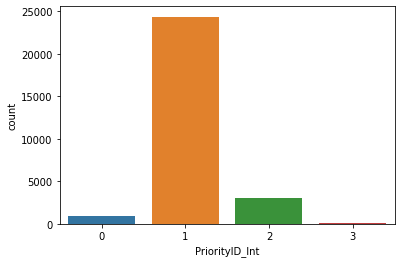

In [28]:
sns.countplot(x="PriorityID_Int", data=ticket_data)

# Build Tokenizer and Apply to Data

## Old Tokenization Flow

In [34]:
type(ticket_data.Notes[1])

str

In [0]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [0]:
ticket_data['tokenized_notes'] = ticket_data.Notes.apply(tokenize_note)

#Truncate the notes to sequences of 512 tokens.
length_threshold = 512
ticket_data['trunc_tokenized_notes'] = ticket_data.tokenized_notes.apply(truncate_tokenized_note, length = length_threshold)

#Create length attributes in df for easy plotting
ticket_data['note_length_notrunc'] = ticket_data.tokenized_notes.apply(len)
ticket_data['note_length_trunc'] = ticket_data.trunc_tokenized_notes.apply(len)

## New Tokenization Flow

In [0]:
max_seq_length = 64

In [0]:
#split into test and train
train_ticket_data, test_ticket_data = train_test_split(ticket_data,test_size = 0.2, shuffle = True)

#dummy class that we can probably remove later. For now, keeping it will give us 
#flexibility if we decide to split tickets based on sentences.
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

#same soft of tokenizer as before
BertTokenizer = bert.bert_tokenization.FullTokenizer
#note that this layer here will be used in the model later.
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=False, name = "BERT")
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_ticket_data.Notes, train_ticket_data.PriorityID_Int)
test_examples = convert_text_to_examples(test_ticket_data.Notes, test_ticket_data.PriorityID_Int)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels ) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, test_labels) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


# EDA


### Note Lengths



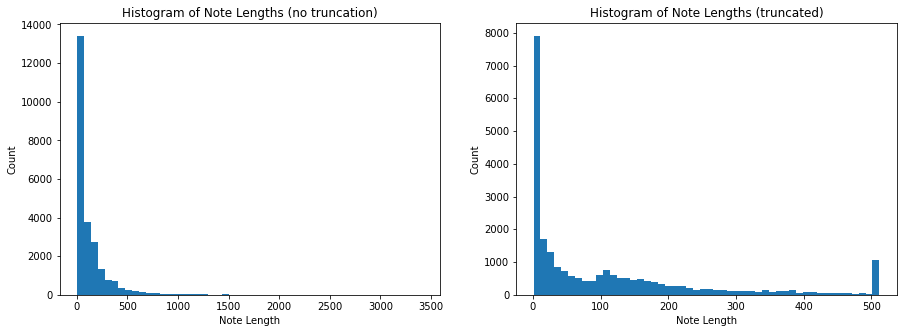

In [42]:
#plot histograms of note lengths
plt.figure(figsize =(15,5))
plt.subplot(121)
plt.hist(ticket_data['note_length_notrunc'], bins = 50)
plt.ylabel('Count')
plt.xlabel('Note Length')
plt.title('Histogram of Note Lengths (no truncation)')

#truncated notes
plt.subplot(122)
plt.hist(ticket_data['note_length_trunc'], bins = 50)
plt.ylabel('Count')
plt.xlabel('Note Length')
plt.title('Histogram of Note Lengths (truncated)')
plt.show()

In [39]:
#calculate the fraction of the notes than are greater than our chosen threshold.
(ticket_data.note_length_notrunc.values > length_threshold).sum()/len(ticket_data.index)

0.0359196923185491

In [40]:
# What is the fraction of notes that are 0 in length?
(ticket_data.note_length_notrunc.values == 0).sum()/len(ticket_data.index)

0.14590169718781976

In [0]:
#Dropping the rows with 0 tokens
ticket_data = ticket_data[ticket_data.note_length_trunc != 0]

### Top Words

In [0]:
from collections import Counter

def count_note_tokens(tokenized_note):
  '''Use only if you need to get token counts for each row on an individual level'''
  counter = Counter()
  tokens = retrieve_true_tokens(tokenized_note)
  for token in tokens:
    counter[token] += 1
  return counter

def retrieve_true_tokens(tokenized_note):
  '''wrapper to get actual tokens from token ids'''
  tokens = tokenizer.convert_ids_to_tokens(tokenized_note)
  return tokens

In [0]:
### NOTE, THIS CELL CAN TAKE AWHILE TO RUN ###
#initialize master counters
notrunc_counter = Counter()
trunc_counter = Counter()

#count the tokens in truncated and full notes
for index, row in ticket_data.iterrows():
  notrunc_tokens = retrieve_true_tokens(row['tokenized_notes'])
  trunc_tokens = retrieve_true_tokens(row['trunc_tokenized_notes'])
  for ntk in notrunc_tokens:
    notrunc_counter[ntk] += 1
  for tk in trunc_tokens:
    trunc_counter[tk] += 1

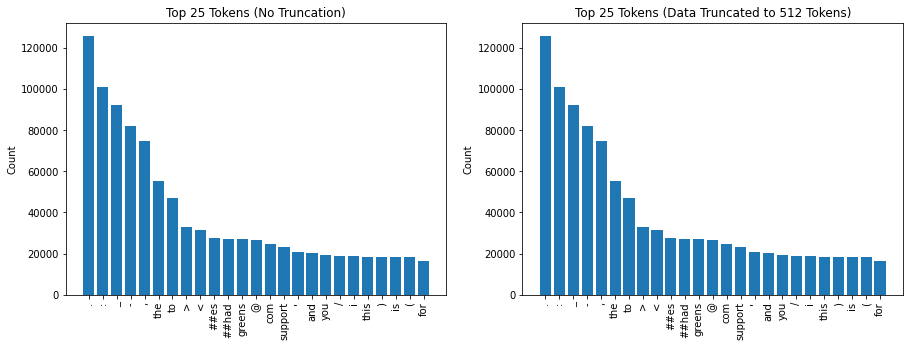

In [45]:
notrunc_top = list(zip(*notrunc_counter.most_common(25)))
trunc_top = list(zip(*notrunc_counter.most_common(25)))

notrunc_top_tokens = notrunc_top[0]
notrunc_top_counts = notrunc_top[1]
trunc_top_tokens = trunc_top[0]
trunc_top_counts = trunc_top[1]


#plot histograms of note lengths
plt.figure(figsize =(15,5))
plt.subplot(121)
plt.bar(notrunc_top_tokens,notrunc_top_counts)
plt.ylabel('Count')
plt.title('Top 25 Tokens (No Truncation)')
plt.xticks(rotation=90)

#truncated notes
plt.subplot(122)
plt.bar(trunc_top_tokens,trunc_top_counts)
plt.ylabel('Count')
plt.title('Top 25 Tokens (Data Truncated to 512 Tokens)')
plt.xticks(rotation=90)
plt.show()

### Bug Actions

In [46]:
# How many unique bugs were tracked?
print(len(set(ticket_data.BugID)))

3769


In [47]:
# How many unique BugActions were tracked?
print(len(ticket_data.BugActionID.unique()))

24206


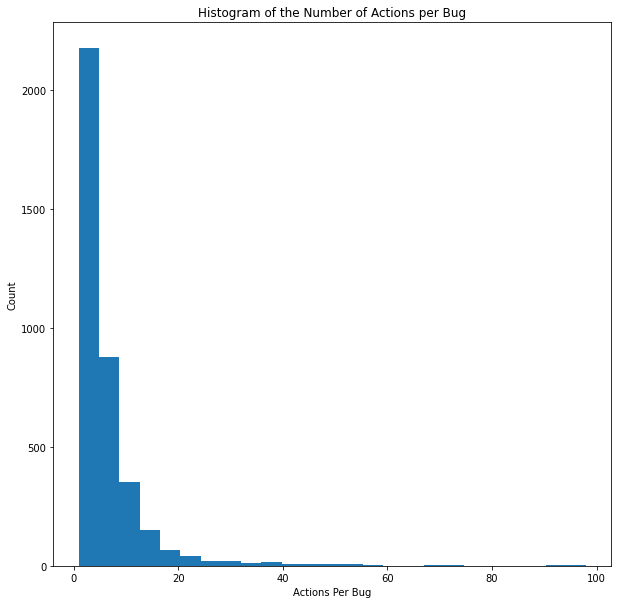

In [48]:
# Create a pivot table of the number of bug actions for each bug
bugID_pivot = pd.pivot_table(ticket_data,values = 'BugActionID',index = 'BugID',aggfunc = 'count').sort_values('BugActionID', ascending = False)

# Histogram of the number of bug actions 
plt.figure(figsize =(10,10))
plt.hist(bugID_pivot.BugActionID, bins = 25)
plt.ylabel('Count')
plt.xlabel('Actions Per Bug')
plt.title('Histogram of the Number of Actions per Bug')
plt.show()

In [49]:
bugID_pivot.sort_values('BugActionID')

,BugActionID
BugID,
506016,1
505769,1
506019,1
505776,1
505775,1
...,...
507359,93
506179,93
508878,95


In [50]:
ticket_data[ticket_data.BugID==444327]

,BugActionID,BugID,ActionUserID,ActionTime,AssignedID,Notes,StatusID,PriorityID,BAContactID,UpdateType,ResolutionID,ClientTouched,CodeChanged,ClientEmailed,ClientPhoned,UserDepartment,UserPosition,NextBugActionID,LastTouchPrevToCloseID,OpenAfterCloseID,NextCloseConfirmedID,RawHours,BusinessHours,LastCloseID,ActionOrder,RedirectStatus,Title,Directory,ProductID,ReportedID,Description,compid,contactid,Originated,KBArticleID,CurrentResolutionID,OpenedTime,LastBugActionID,WasLow,WasAssignedToDev,LastBugActionStatus,NumBugActions,LastContact,WasEscalatedPastRepLevel,WorkspaceID,Summary,ClientTemp,MajorityPriorityID,SupportFailbyDev,SupportFailConfirm,Classification,HighestPriorityID,owner,IsEFP,LastRedirectStatus,ChangeDateTime,HistorySummary,HistoryClientTemp,UserID,ClosestBugActionID,ArticleID,KBTitle,NumUses,NumTimesEscalated,DefaultPriorityID,PackageID,KBProductID,Active,UserFriendlyDesc,SalesProductGroupID,DefaultClassification,PriorityID_Int,clean_notes,tokenized_notes,trunc_tokenized_notes,note_length_notrunc,note_length_trunc


It looks like the majority of bugs have very few actions. What is the average?

In [51]:
#Calculate average number of actions/bug
print(np.mean(bugID_pivot.BugActionID))

6.4223932077474135


Clearly, most of the time there is only one action per bug, but what do the notes look like for these?

In [52]:
stop = 0
stop_threshold = 10
for index,note in enumerate(ticket_data.Notes[ticket_data.BugID.isin(list(bugID_pivot[bugID_pivot.BugActionID ==1].index))]):
  print('Note #%i:\n%s\n'%(index + 1,note))
  stop += 1
  if stop >= stop_threshold:
    break

Note #1:
(Created)

Note #2:
(Created)

Note #3:
(Created)

Note #4:
(Created)

Note #5:
(Created)

Note #6:
(Created)

Note #7:
(Created)

Note #8:
(Created)

Note #9:
(Created)

Note #10:
(Created)



In [60]:
len(ticket_data[ticket_data.Notes != '(Created)'])

20492

### Categorical Features

In [0]:
ticket_data.columns

Index(['BugActionID', 'BugID', 'ActionUserID', 'ActionTime', 'AssignedID',
       'Notes', 'StatusID', 'PriorityID', 'BAContactID', 'UpdateType',
       'ResolutionID', 'ClientTouched', 'CodeChanged', 'ClientEmailed',
       'ClientPhoned', 'UserDepartment', 'UserPosition', 'NextBugActionID',
       'LastTouchPrevToCloseID', 'OpenAfterCloseID', 'NextCloseConfirmedID',
       'RawHours', 'BusinessHours', 'LastCloseID', 'ActionOrder',
       'RedirectStatus', 'Title', 'Directory', 'ProductID', 'ReportedID',
       'Description', 'compid', 'contactid', 'Originated', 'KBArticleID',
       'CurrentResolutionID', 'OpenedTime', 'LastBugActionID', 'WasLow',
       'WasAssignedToDev', 'LastBugActionStatus', 'NumBugActions',
       'LastContact', 'WasEscalatedPastRepLevel', 'WorkspaceID', 'Summary',
       'ClientTemp', 'MajorityPriorityID', 'SupportFailbyDev',
       'SupportFailConfirm', 'Classification', 'HighestPriorityID', 'owner',
       'IsEFP', 'LastRedirectStatus', 'ChangeDateTime', 'Hi